In [1]:
import os
import pandas as pd
import numpy as np
import csv
from tqdm import tqdm
from rouge import Rouge
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
rouge = Rouge()
os.getcwd()


'/model'

## FBQA

In [2]:
fbqa = pd.read_json("/datasets/FreebaseQA/FreebaseQA-eval.json")

In [3]:
answers = fbqa.Questions.apply(lambda t: t["Parses"][0]["Answers"][0]["AnswersName"][0].split(" "))
answers.head()

0      [sandi, toksvig]
1        [henry, fonda]
2      [terry, gilliam]
3      [steve, mcqueen]
4    [harold, abrahams]
Name: Questions, dtype: object

In [4]:
bline_fbqa_df = pd.read_csv("/datasets/FreebaseQA/results/baseline/m7b.csv", header=None)
bline_fbqa_df.rename(columns={0: "Model"}, inplace=True)
bline_fbqa_df["Actual"] = answers.apply(" ".join)
bline_fbqa_df["Model"] = bline_fbqa_df["Model"].apply(str.lower)
# check correct answer is present in the output
bline_fbqa_df["Correct"] = bline_fbqa_df.apply(lambda t: t[1] in t[0], axis=1)
bline_fbqa_df.head()

/tmp/ipykernel_898/423993629.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bline_fbqa_df["Correct"] = bline_fbqa_df.apply(lambda t: t[1] in t[0], axis=1)


,Model,Actual,Correct
0,anita rani,sandi toksvig,False
1,mervyn leroy produced the film 12 angry men.,henry fonda,False
2,terry gilliam,terry gilliam,True
3,steve mcqueen,steve mcqueen,True
4,harold abrahams,harold abrahams,True


In [5]:
print(
    f"Baseline Accuracy: {sum(bline_fbqa_df.Correct)/len(bline_fbqa_df):.3f}"
)

Baseline Accuracy: 0.736


In [6]:
print(bline_fbqa_df.iloc[135])
rouge.get_scores(bline_fbqa_df.iloc[135].Model, bline_fbqa_df.iloc[135].Actual)


Model          pickwick papers
Actual     the pickwick papers
Correct                  False
Name: 135, dtype: object


[{'rouge-1': {'r': 0.6666666666666666, 'p': 1.0, 'f': 0.7999999952000001},
  'rouge-2': {'r': 0.5, 'p': 1.0, 'f': 0.6666666622222223},
  'rouge-l': {'r': 0.6666666666666666, 'p': 1.0, 'f': 0.7999999952000001}}]

### Extract f1 values of ROUGE (1-gram,2-gram,LCS overlap)


In [45]:
metrics = ["rouge-1", "rouge-2", "rouge-l"]

for i, r in bline_fbqa_df.iterrows():
    # print(bline_fbqa_df.loc[i, metrics[0]])
    scores = rouge.get_scores(r.Model, r.Actual)
    for metric in metrics:
        bline_fbqa_df.loc[i, metric] = round(scores[0][metric]["r"], 3)
bline_fbqa_df.head()

,Model,Actual,Correct,rouge-1,rouge-2,rouge-l,CorrectS
0,anita rani,sandi toksvig,False,0.0,0.0,0.0,0
1,mervyn leroy produced the film 12 angry men.,henry fonda,False,0.0,0.0,0.0,0
2,terry gilliam,terry gilliam,True,1.0,1.0,1.0,1
3,steve mcqueen,steve mcqueen,True,1.0,1.0,1.0,1
4,harold abrahams,harold abrahams,True,1.0,1.0,1.0,1


3996


,rouge-1,rouge-2,rouge-l
count,3996.000000,3996.000000,3996.000000
mean,0.693483,0.375059,0.691759
std,0.431704,0.474771,0.431758
min,0.000000,0.000000,0.000000
25%,0.191750,0.000000,0.191750
50%,1.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000


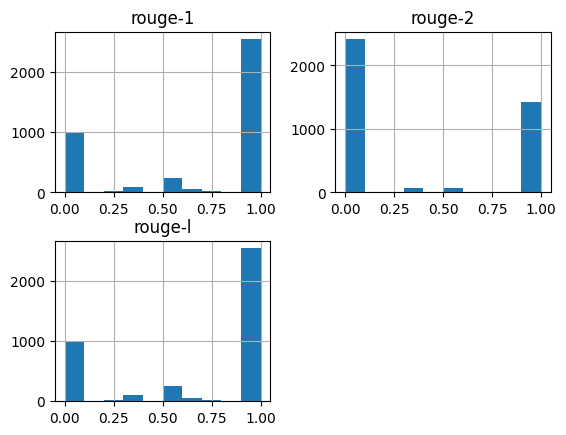

In [46]:
print(len(bline_fbqa_df))
bline_fbqa_df[metrics].hist(bins=10)
bline_fbqa_df[metrics].describe()

(array([785.,   0.,   0.,   2.,   1.,   5.,  14.,   0.,  48.,   6.]),
 array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ]),
 <BarContainer object of 10 artists>)

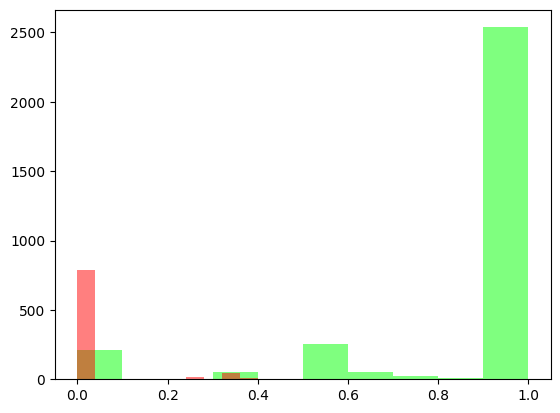

In [47]:
bline_fbqa_df["CorrectS"] = bline_fbqa_df.apply(lambda t: 1 if t.Correct else 0, axis=1)
fbqa_correct = bline_fbqa_df[bline_fbqa_df.Correct]
fbqa_wrong = bline_fbqa_df[~bline_fbqa_df.Correct]

fig, ax = plt.subplots(nrows=1, ncols=1)

ax.hist(fbqa_correct["rouge-l"], fc=(0, 1, 0, 0.5))
ax.hist(fbqa_wrong["rouge-l"], fc=(1, 0,0,0.5))
# bline_fbqa_df.plot.scatter(x="rouge-l", y="CorrectS")

In [10]:
fbqa_correct[fbqa_correct["rouge-l"] == 0]

,Model,Actual,Correct,rouge-1,rouge-2,rouge-l,CorrectS
8,"helsinki, finland",helsinki,True,0.0,0.0,0.0,1
19,"moscow, russia",moscow,True,0.0,0.0,0.0,1
24,"seoul, south korea",seoul,True,0.0,0.0,0.0,1
53,"""hugo"" is the 2011 drama film, directed by mar...",hugo,True,0.0,0.0,0.0,1
56,"paris, using an arrow dipped in the venom of a...",paris,True,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...
3885,calvin harris (rihanna was the lead vocalist),rihanna,True,0.0,0.0,0.0,1
3911,"khartoum, sudan",khartoum,True,0.0,0.0,0.0,1
3929,"""hamlet"" is shakespeare's longest play.",hamlet,True,0.0,0.0,0.0,1
3933,"""the gunfight at the o.k. corral"" is not the c...",high noon,True,0.0,0.0,0.0,1


### The truly correct answer is inside + rouge-l >= 0.5

In [11]:
fbqa_wrong[(fbqa_wrong["rouge-l"] >= 0.5) & ~(fbqa_wrong["rouge-l"] == 1)]

,Model,Actual,Correct,rouge-1,rouge-2,rouge-l,CorrectS
15,leeds united,leeds united f.c.,False,0.500,0.333,0.500,0
16,bobby moore and alan devonshire,alan taylor,False,0.500,0.000,0.500,0
18,seb coe,sebastian coe,False,0.500,0.000,0.500,0
106,federal reserve,federal reserve system,False,0.667,0.500,0.667,0
107,manhattan transfer,the manhattan transfer,False,0.667,0.500,0.667,0
...,...,...,...,...,...,...,...
3825,james sherman,james s. sherman,False,0.667,0.000,0.667,0
3828,tennis,table tennis,False,0.500,0.000,0.500,0
3923,dutch,dutch people,False,0.500,0.000,0.500,0
3934,the chiltern hills,quantock hills,False,0.500,0.000,0.500,0


In [12]:
bline_fbqa_df["Correct"] = bline_fbqa_df.apply(lambda t: t.Correct + t["rouge-l"] >= 0.5, axis=1)

In [13]:
print(
    f"Baseline Accuracy: {sum(bline_fbqa_df.Correct)/len(bline_fbqa_df):.3f}"
)

Baseline Accuracy: 0.785


## MetaQA

In [14]:
def check_metaqa_answer_correct(Answer, Model):
    max_r = 0
    for a in Answer:
        for m in Model:
            if m and a:
                scores = rouge.get_scores(m, a)[0]
                if scores["rouge-l"]["r"] > max_r:
                    max_r = scores["rouge-l"]["r"]
    return max_r

## MetaQA 1hop

## TODO: look into several-shot answers

In [15]:
metaqa = pd.read_csv("/datasets/MetaQA/1hop/qa_test.txt", sep="\t", header=None)
print(len(metaqa))
metaqa.rename(columns={0: "Question", 1: "Answers"}, inplace=True)
metaqa.Answers = metaqa.apply(lambda t: set(t.Answers.lower().split("|")), axis=1)
bline_metaqa_df = pd.read_csv("/datasets/MetaQA/results/1hop/bline.csv")
print(len(bline_metaqa_df))
metaqa.insert(2, "Model", bline_metaqa_df.Model)
metaqa.head()

9947
9947


,Question,Answers,Model
0,what does [Grégoire Colin] appear in,{before the rain},"Grégoire Colin appears in ""The Hundred-Foot Jo..."
1,[Joe Thomas] appears in which movies,"{the inbetweeners movie, the inbetweeners 2}","""Rocky Balboa, A Cinderella Story, The Dark Kn..."
2,what films did [Michelle Trachtenberg] star in,"{inspector gadget, the scribbler, ice princess...","""Harold & Kumar Go to White Castle, EuroTrip, ..."
3,what does [Helen Mack] star in,"{the son of kong, divorce, kiss and make-up}","""The Maltese Falcon"" | ""Susan and God"""
4,what films did [Shahid Kapoor] act in,"{haider, chance pe dance, jab we met}","""Haider, Udta Punjab, Padmaavat, Kabir Singh, ..."


In [17]:
metaqa.Model.fillna("", inplace=True)
metaqa.Model = metaqa.apply(lambda t: set(t.Model.lower().split("|")), axis=1)
metaqa.head()

/tmp/ipykernel_898/1742900988.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  metaqa.Model.fillna("", inplace=True)


,Question,Answers,Model
0,what does [Grégoire Colin] appear in,{before the rain},"{grégoire colin appears in ""the hundred-foot j..."
1,[Joe Thomas] appears in which movies,"{the inbetweeners movie, the inbetweeners 2}","{""rocky balboa, a cinderella story, the dark k..."
2,what films did [Michelle Trachtenberg] star in,"{inspector gadget, the scribbler, ice princess...","{""harold & kumar go to white castle, eurotrip,..."
3,what does [Helen Mack] star in,"{the son of kong, divorce, kiss and make-up}","{""the maltese falcon"" , ""susan and god""}"
4,what films did [Shahid Kapoor] act in,"{haider, chance pe dance, jab we met}","{""haider, udta punjab, padmaavat, kabir singh,..."


In [18]:
metaqa.iloc[2].Answers

{'black christmas',
 'harriet the spy',
 'ice princess',
 'inspector gadget',
 'the scribbler'}

In [19]:
metaqa["rouge-l"] = metaqa.apply(lambda t: check_metaqa_answer_correct(t.Answers, t.Model), axis=1)
metaqa.head()

,Question,Answers,Model,rouge-l
0,what does [Grégoire Colin] appear in,{before the rain},"{grégoire colin appears in ""the hundred-foot j...",0.000000
1,[Joe Thomas] appears in which movies,"{the inbetweeners movie, the inbetweeners 2}","{""rocky balboa, a cinderella story, the dark k...",0.333333
2,what films did [Michelle Trachtenberg] star in,"{inspector gadget, the scribbler, ice princess...","{""harold & kumar go to white castle, eurotrip,...",1.000000
3,what does [Helen Mack] star in,"{the son of kong, divorce, kiss and make-up}","{""the maltese falcon"" , ""susan and god""}",0.333333
4,what films did [Shahid Kapoor] act in,"{haider, chance pe dance, jab we met}","{""haider, udta punjab, padmaavat, kabir singh,...",0.666667


array([[<Axes: title={'center': 'rouge-l'}>]], dtype=object)

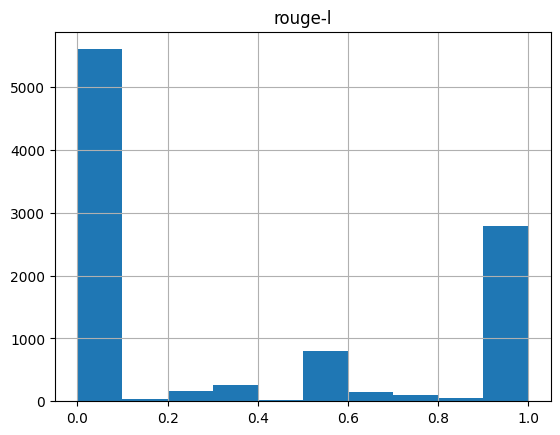

In [20]:
metaqa.hist()

In [21]:
metaqa["Correct"] = metaqa.apply(lambda t: t["rouge-l"] >= 0.5, axis=1)
metaqa.head()

,Question,Answers,Model,rouge-l,Correct
0,what does [Grégoire Colin] appear in,{before the rain},"{grégoire colin appears in ""the hundred-foot j...",0.000000,False
1,[Joe Thomas] appears in which movies,"{the inbetweeners movie, the inbetweeners 2}","{""rocky balboa, a cinderella story, the dark k...",0.333333,False
2,what films did [Michelle Trachtenberg] star in,"{inspector gadget, the scribbler, ice princess...","{""harold & kumar go to white castle, eurotrip,...",1.000000,True
3,what does [Helen Mack] star in,"{the son of kong, divorce, kiss and make-up}","{""the maltese falcon"" , ""susan and god""}",0.333333,False
4,what films did [Shahid Kapoor] act in,"{haider, chance pe dance, jab we met}","{""haider, udta punjab, padmaavat, kabir singh,...",0.666667,True


In [22]:
print(
    f"Baseline Accuracy: {sum(metaqa.Correct)/len(metaqa):.3f}"
)

Baseline Accuracy: 0.391


## MetaQA (2-hop)

In [23]:
metaqa2hop = pd.read_csv("/datasets/MetaQA/2hop/qa_test.txt", sep="\t", header=None)
print(len(metaqa2hop))
metaqa2hop.rename(columns={0: "Question", 1: "Answers"}, inplace=True)
metaqa2hop.Answers = metaqa2hop.apply(lambda t: set(t.Answers.lower().split("|")), axis=1)
bline_metaqa2_df = pd.read_csv("/datasets/MetaQA/results/2hop/bline.csv")
print(len(bline_metaqa2_df))
metaqa2hop.insert(2, "Model", bline_metaqa2_df.Model)
metaqa2hop.head()

14872
14872


,Question,Answers,Model
0,which person directed the movies starred by [J...,"{nancy meyers, sam mendes, ken kwapis, george ...","J.J. Abrams, Mira Nair, and John Krasinski (fo..."
1,who are movie co-directors of [Delbert Mann],"{robert stevenson, cary fukunaga, franco zeffi...","Franklin J. Schaffner, Robert Mulligan, John F..."
2,what are the primary languages in the movies d...,{german},There are no movies directed by David Mandel f...
3,the screenwriter [Mimsy Farmer] co-wrote movie...,{barbet schroeder},"Woody Allen (Sleeper, Bananas) | John Sayles (..."
4,the films acted by [Shaun White] were in which...,"{sport, documentary}","Action, Sports, Biography"


In [24]:
metaqa2hop.Model.isna().sum()

np.int64(0)

In [25]:
metaqa2hop.Model.fillna("", inplace=True)
metaqa2hop.Model = metaqa2hop.apply(lambda t: set(t.Model.lower().split("|")), axis=1)
metaqa2hop.head()

/tmp/ipykernel_898/3492113738.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  metaqa2hop.Model.fillna("", inplace=True)


,Question,Answers,Model
0,which person directed the movies starred by [J...,"{nancy meyers, sam mendes, ken kwapis, george ...","{j.j. abrams, mira nair, and john krasinski (f..."
1,who are movie co-directors of [Delbert Mann],"{robert stevenson, cary fukunaga, franco zeffi...","{franklin j. schaffner, robert mulligan, john ..."
2,what are the primary languages in the movies d...,{german},{there are no movies directed by david mandel ...
3,the screenwriter [Mimsy Farmer] co-wrote movie...,{barbet schroeder},"{ john sayles (piranha, the howling), woody al..."
4,the films acted by [Shaun White] were in which...,"{sport, documentary}","{action, sports, biography}"


In [26]:
metaqa2hop["rouge-l"] = metaqa2hop.apply(lambda t: check_metaqa_answer_correct(t.Answers, t.Model), axis=1)
metaqa2hop.head()

,Question,Answers,Model,rouge-l
0,which person directed the movies starred by [J...,"{nancy meyers, sam mendes, ken kwapis, george ...","{j.j. abrams, mira nair, and john krasinski (f...",0.0
1,who are movie co-directors of [Delbert Mann],"{robert stevenson, cary fukunaga, franco zeffi...","{franklin j. schaffner, robert mulligan, john ...",0.5
2,what are the primary languages in the movies d...,{german},{there are no movies directed by david mandel ...,0.0
3,the screenwriter [Mimsy Farmer] co-wrote movie...,{barbet schroeder},"{ john sayles (piranha, the howling), woody al...",0.0
4,the films acted by [Shaun White] were in which...,"{sport, documentary}","{action, sports, biography}",0.0


array([[<Axes: title={'center': 'rouge-l'}>]], dtype=object)

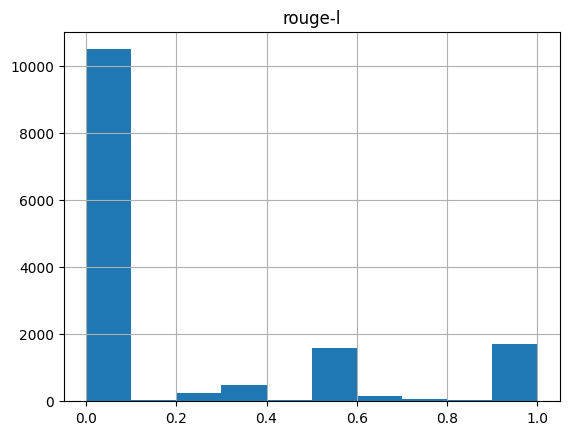

In [27]:
metaqa2hop.hist()

In [28]:
metaqa2hop["Correct"] = metaqa2hop.apply(lambda t: t["rouge-l"] >= 0.5, axis=1)
metaqa2hop.head()

,Question,Answers,Model,rouge-l,Correct
0,which person directed the movies starred by [J...,"{nancy meyers, sam mendes, ken kwapis, george ...","{j.j. abrams, mira nair, and john krasinski (f...",0.0,False
1,who are movie co-directors of [Delbert Mann],"{robert stevenson, cary fukunaga, franco zeffi...","{franklin j. schaffner, robert mulligan, john ...",0.5,True
2,what are the primary languages in the movies d...,{german},{there are no movies directed by david mandel ...,0.0,False
3,the screenwriter [Mimsy Farmer] co-wrote movie...,{barbet schroeder},"{ john sayles (piranha, the howling), woody al...",0.0,False
4,the films acted by [Shaun White] were in which...,"{sport, documentary}","{action, sports, biography}",0.0,False


In [29]:
print(
    f"Baseline Accuracy: {sum(metaqa2hop.Correct)/len(metaqa2hop):.3f}"
)

Baseline Accuracy: 0.239


## MetaQA 3-hop

In [30]:
metaqa3hop = pd.read_csv("/datasets/MetaQA/3hop/qa_test.txt", sep="\t", header=None)
print(len(metaqa3hop))
metaqa3hop.rename(columns={0: "Question", 1: "Answers"}, inplace=True)
metaqa3hop.Answers = metaqa3hop.apply(lambda t: set(t.Answers.lower().split("|")), axis=1)
bline_metaqa3_df = pd.read_csv("/datasets/MetaQA/results/3hop/bline.csv")
print(len(bline_metaqa3_df))
metaqa3hop.insert(2, "Model", bline_metaqa3_df.Model)
metaqa3hop.head()

14274
14274


,Question,Answers,Model
0,the films that share directors with the film [...,"{german, polish, japanese, mende}","English, German, French, Italian, Spanish"
1,who starred movies for the director of [Writte...,"{susan kohner, cornel wilde, joan bennett, lan...","Douglas Fairbanks Jr., Robert Stack, Rock Huds..."
2,the films that share actors with the film [Cre...,"{polish, english}","English, Spanish, French, Italian, German"
3,what were the release years of the films that ...,"{2000, 2002, 1998, 2008, 2011, 1999, 1996, 199...","2010, 2011, 2012, 2013, 2014, 2015 (for films ..."
4,who is listed as director of the films starred...,"{gary trousdale, jean delannoy, stephen frears...","Ken Kwapis, James Foley, and Jon M. Chu (varie..."


In [31]:
metaqa3hop.Model.isna().sum()

np.int64(0)

In [32]:
metaqa3hop.Model.fillna("", inplace=True)
metaqa3hop.Model = metaqa3hop.apply(lambda t: set(t.Model.lower().split("|")), axis=1)
metaqa3hop.head()

/tmp/ipykernel_898/4283186107.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  metaqa3hop.Model.fillna("", inplace=True)


,Question,Answers,Model
0,the films that share directors with the film [...,"{german, polish, japanese, mende}","{english, german, french, italian, spanish}"
1,who starred movies for the director of [Writte...,"{susan kohner, cornel wilde, joan bennett, lan...","{douglas fairbanks jr., robert stack, rock hud..."
2,the films that share actors with the film [Cre...,"{polish, english}","{english, spanish, french, italian, german}"
3,what were the release years of the films that ...,"{2000, 2002, 1998, 2008, 2011, 1999, 1996, 199...","{2010, 2011, 2012, 2013, 2014, 2015 (for films..."
4,who is listed as director of the films starred...,"{gary trousdale, jean delannoy, stephen frears...","{ken kwapis, james foley, and jon m. chu (vari..."


In [33]:
metaqa3hop["rouge-l"] = metaqa3hop.apply(lambda t: check_metaqa_answer_correct(t.Answers, t.Model), axis=1)
metaqa3hop.head()

,Question,Answers,Model,rouge-l
0,the films that share directors with the film [...,"{german, polish, japanese, mende}","{english, german, french, italian, spanish}",0.000000
1,who starred movies for the director of [Writte...,"{susan kohner, cornel wilde, joan bennett, lan...","{douglas fairbanks jr., robert stack, rock hud...",0.500000
2,the films that share actors with the film [Cre...,"{polish, english}","{english, spanish, french, italian, german}",0.000000
3,what were the release years of the films that ...,"{2000, 2002, 1998, 2008, 2011, 1999, 1996, 199...","{2010, 2011, 2012, 2013, 2014, 2015 (for films...",0.000000
4,who is listed as director of the films starred...,"{gary trousdale, jean delannoy, stephen frears...","{ken kwapis, james foley, and jon m. chu (vari...",0.333333


array([[<Axes: title={'center': 'rouge-l'}>]], dtype=object)

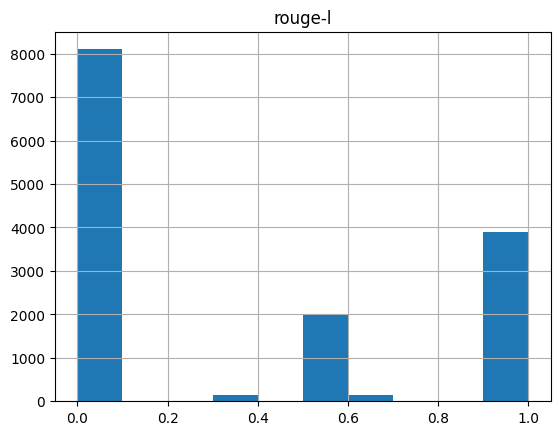

In [34]:
metaqa3hop.hist()

In [35]:
metaqa3hop["Correct"] = metaqa3hop.apply(lambda t: t["rouge-l"] >= 0.5, axis=1)
metaqa3hop.head()

,Question,Answers,Model,rouge-l,Correct
0,the films that share directors with the film [...,"{german, polish, japanese, mende}","{english, german, french, italian, spanish}",0.000000,False
1,who starred movies for the director of [Writte...,"{susan kohner, cornel wilde, joan bennett, lan...","{douglas fairbanks jr., robert stack, rock hud...",0.500000,True
2,the films that share actors with the film [Cre...,"{polish, english}","{english, spanish, french, italian, german}",0.000000,False
3,what were the release years of the films that ...,"{2000, 2002, 1998, 2008, 2011, 1999, 1996, 199...","{2010, 2011, 2012, 2013, 2014, 2015 (for films...",0.000000,False
4,who is listed as director of the films starred...,"{gary trousdale, jean delannoy, stephen frears...","{ken kwapis, james foley, and jon m. chu (vari...",0.333333,False


In [36]:
print(
    f"Baseline Accuracy: {sum(metaqa3hop.Correct)/len(metaqa3hop):.3f}"
)

Baseline Accuracy: 0.422


## CosmosQA

In [37]:
csqa = pd.read_csv("/datasets/CosmosQA/valid.csv")
print(len(csqa))
csqa.head()

2985


,id,context,question,answer0,answer1,answer2,answer3,label
0,3BFF0DJK8XA7YNK4QYIGCOG1A95STE##3180JW2OT5AF02...,Do i need to go for a legal divorce ? I wanted...,Why is this person asking about divorce ?,If he gets married in the church he wo nt have...,He wants to get married to a different person .,He wants to know if he does nt like this girl ...,None of the above choices .,1
1,3BFF0DJK8XA7YNK4QYIGCOG1A95STE##3180JW2OT5AF02...,Do i need to go for a legal divorce ? I wanted...,Why is he worried about getting married ?,He was married before and she might come back ...,He wants the girl he is going to marry get in ...,He knows that he will be committing polygamy .,None of the above choices .,0
2,3AXFSPQOYQW4GFJD8K4D3JADN54FJ9##352YTHGROWB1DD...,"I was walking home from the store , when I saw...",What may happen after the young man makes his ...,An ambulance would likely come to the scene,The taxi would pick up the young man,None of the above choices .,The bus would arrive at the stop soon,0
3,3AXFSPQOYQW4GFJD8K4D3JADN54FJ9##352YTHGROWB1DD...,"I was walking home from the store , when I saw...",What may happen after the young man makes his ...,None of the above choices .,The bus would arrive at the stop soon,The taxi would pick up the young man,Medical personnel would come to help the old man,3
4,3AXFSPQOYQW4GFJD8K4D3JADN54FJ9##352YTHGROWB1DD...,"I was walking home from the store , when I saw...",What may have happened to the old man ?,He was waiting on a ride,He likely fell on the sidewalk and hit his hea...,He was waiting on the taxi,None of the above choices .,1


In [38]:
let_to_digit_map = {"A": 0, "B": 1, "C": 2, "D": 3}

In [76]:
csqa_bline = pd.read_csv("/datasets/CosmosQA/results/bline2.csv")
print(len(csqa_bline))
csqa_bline.Model = csqa_bline.apply(lambda t: let_to_digit_map[t.Model[0]], axis=1)
csqa.insert(8, "Model", csqa_bline.Model)
csqa.head()

2985


NameError: name 'let_to_digit_map' is not defined

In [40]:
csqa["Correct"] = csqa.apply(lambda t: int(t.label) == int(t.Model), axis=1)
csqa.head()

,id,context,question,answer0,answer1,answer2,answer3,label,Model,Correct
0,3BFF0DJK8XA7YNK4QYIGCOG1A95STE##3180JW2OT5AF02...,Do i need to go for a legal divorce ? I wanted...,Why is this person asking about divorce ?,If he gets married in the church he wo nt have...,He wants to get married to a different person .,He wants to know if he does nt like this girl ...,None of the above choices .,1,1,True
1,3BFF0DJK8XA7YNK4QYIGCOG1A95STE##3180JW2OT5AF02...,Do i need to go for a legal divorce ? I wanted...,Why is he worried about getting married ?,He was married before and she might come back ...,He wants the girl he is going to marry get in ...,He knows that he will be committing polygamy .,None of the above choices .,0,2,False
2,3AXFSPQOYQW4GFJD8K4D3JADN54FJ9##352YTHGROWB1DD...,"I was walking home from the store , when I saw...",What may happen after the young man makes his ...,An ambulance would likely come to the scene,The taxi would pick up the young man,None of the above choices .,The bus would arrive at the stop soon,0,0,True
3,3AXFSPQOYQW4GFJD8K4D3JADN54FJ9##352YTHGROWB1DD...,"I was walking home from the store , when I saw...",What may happen after the young man makes his ...,None of the above choices .,The bus would arrive at the stop soon,The taxi would pick up the young man,Medical personnel would come to help the old man,3,3,True
4,3AXFSPQOYQW4GFJD8K4D3JADN54FJ9##352YTHGROWB1DD...,"I was walking home from the store , when I saw...",What may have happened to the old man ?,He was waiting on a ride,He likely fell on the sidewalk and hit his hea...,He was waiting on the taxi,None of the above choices .,1,1,True


In [41]:
print(
    f"Baseline Accuracy: {sum(csqa.Correct)/len(csqa):.3f}"
)

Baseline Accuracy: 0.677
